In [1]:
from google.colab import drive
import os
import shutil

# Monter Google Drive
drive.mount('/content/drive')

# Chemin du fichier ZIP dans Google Drive
zip_path_drive = "/content/drive/MyDrive/datasets/plantvillage_color.zip"

# Chemin du fichier ZIP dans l'arborescence Colab
zip_path_colab = "/content/plantvillage_color.zip"

# Chemin du répertoire de destination pour la décompression
extract_path = "/content/plantvillage_color"

# Supprimer le répertoire s'il existe
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
    print(f"Répertoire {extract_path} supprimé")

# Créer le répertoire de destination
os.makedirs(extract_path)

# Copier le fichier ZIP de Google Drive vers Colab
shutil.copy(zip_path_drive, zip_path_colab)
print(f"Fichier {zip_path_drive} copié vers {zip_path_colab}")

# Décompresser le fichier ZIP en conservant l'arborescence
os.system(f'unzip {zip_path_colab} -d {extract_path}')

print(f"Fichier {zip_path_colab} décompressé dans {extract_path}")


Mounted at /content/drive
Fichier /content/drive/MyDrive/datasets/plantvillage_color.zip copié vers /content/plantvillage_color.zip
Fichier /content/plantvillage_color.zip décompressé dans /content/plantvillage_color


In [2]:
from google.colab import drive
import os
import shutil
import datetime

# Monter Google Drive
drive.mount('/content/drive')

# Fonction pour créer un nom de modèle unique
def create_model_name(model_type, params):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_name = f"{model_type}_{params['image_size']}x{params['image_size']}_B{params['batch_size']}_LR{params['learning_rate']}_E{params['epochs']}_{timestamp}"
    return model_name

# Configurations
base_dir = '/content/drive/My Drive/ColabResults/'
image_size = 224
batch_size = 32
epochs = 20
learning_rate = 0.0001
model_type = "CNN_Model"
params = {
    'image_size': image_size,
    'batch_size': batch_size,
    'epochs': epochs,
    'learning_rate': learning_rate,
}

# Créer le nom du modèle et le répertoire unique
model_name = create_model_name(model_type, params)
model_dir = os.path.join(base_dir, model_name)
os.makedirs(model_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

# Fixer les graines pour la reproductibilité
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Configurations
image_size = 224
batch_size = 32
validation_split = 0.2

# Chemin vers les données
base_dir_data = "/content/plantvillage_color/content/plantvillage-dataset/plantvillage dataset/color"

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Création des datasets avec validation split
train_dataset = image_dataset_from_directory(
    base_dir_data,
    validation_split=validation_split,
    subset='training',
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    base_dir_data,
    validation_split=validation_split,
    subset='validation',
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

# Obtenir les noms des classes
class_names = train_dataset.class_names

# Normalisation des datasets
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))

# Calcul des steps_per_epoch et validation_steps
num_train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
num_val_batches = tf.data.experimental.cardinality(validation_dataset).numpy()
steps_per_epoch = num_train_batches
validation_steps = num_val_batches

print(f"Nombre total de batches d'entraînement: {num_train_batches}")
print(f"Nombre total de batches de validation: {num_val_batches}")

# Appliquer .repeat() après avoir obtenu les noms des classes
train_dataset = train_dataset.repeat()
validation_dataset = validation_dataset.repeat()



Found 54279 files belonging to 38 classes.
Using 43424 files for training.
Found 54279 files belonging to 38 classes.
Using 10855 files for validation.
Nombre total de batches d'entraînement: 1357
Nombre total de batches de validation: 340


In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Définition du modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Afficher le résumé du modèle
model.summary()

# Compilation du modèle avec un taux d'apprentissage réduit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [5]:

# Entraîner le modèle
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)



Epoch 1/20
1357/1357 [==============================] - 101s 70ms/step - loss: 1.3356 - accuracy: 0.6345 - val_loss: 0.7588 - val_accuracy: 0.7800
Epoch 2/20
1357/1357 [==============================] - 93s 68ms/step - loss: 0.5951 - accuracy: 0.8245 - val_loss: 0.5633 - val_accuracy: 0.8253
Epoch 3/20
1357/1357 [==============================] - 91s 67ms/step - loss: 0.4066 - accuracy: 0.8776 - val_loss: 0.4585 - val_accuracy: 0.8632
Epoch 4/20
1357/1357 [==============================] - 90s 66ms/step - loss: 0.3027 - accuracy: 0.9106 - val_loss: 0.4049 - val_accuracy: 0.8762
Epoch 5/20
1357/1357 [==============================] - 90s 66ms/step - loss: 0.2213 - accuracy: 0.9352 - val_loss: 0.3765 - val_accuracy: 0.8843
Epoch 6/20
1357/1357 [==============================] - 90s 67ms/step - loss: 0.1628 - accuracy: 0.9534 - val_loss: 0.3447 - val_accuracy: 0.8969
Epoch 7/20
1357/1357 [==============================] - 100s 73ms/step - loss: 0.1204 - accuracy: 0.9664 - val_loss: 0.3518

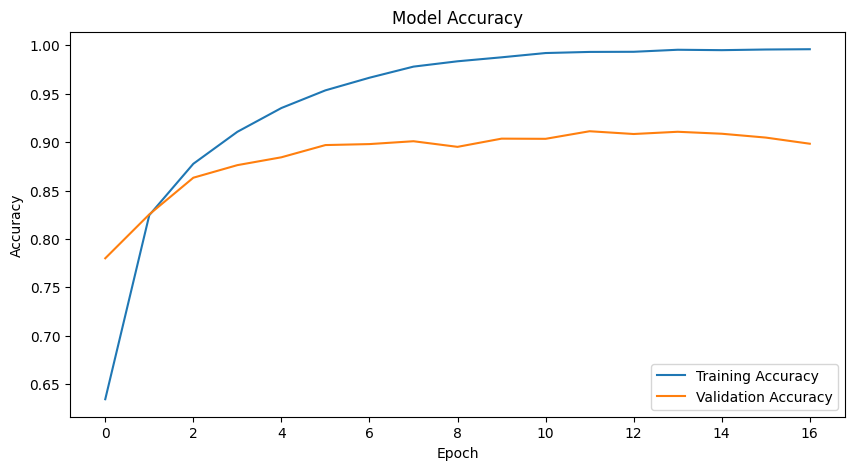

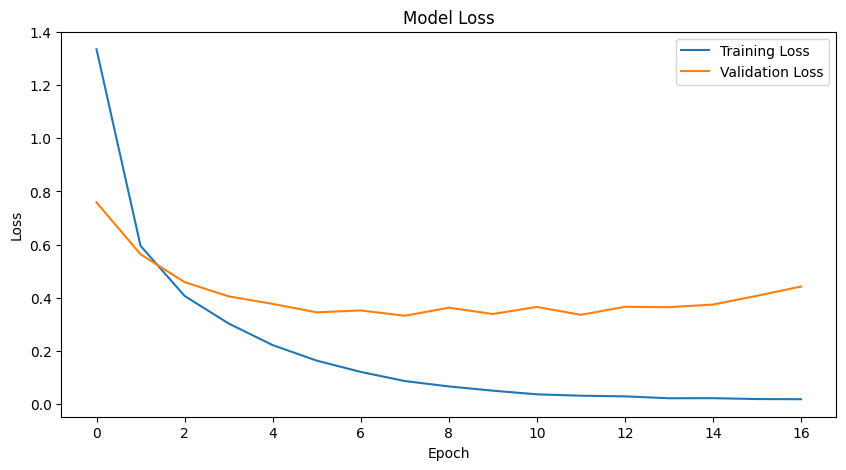

In [6]:
import matplotlib.pyplot as plt

# Visualisation des résultats
def plot_metrics(history, model_dir):
    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(model_dir, 'model_accuracy.png'))  # Sauvegarder le graphe d'accuracy
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(model_dir, 'model_loss.png'))  # Sauvegarder le graphe de perte
    plt.show()

plot_metrics(history, model_dir)



In [7]:
from sklearn.metrics import classification_report

# Prédictions sur les données de validation
val_dataset_no_repeat = validation_dataset.take(validation_steps)  # Assurez-vous de ne pas répéter le dataset pour l'évaluation
y_true = []
y_pred = []

for images, labels in val_dataset_no_repeat:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Obtenir les classes uniques dans y_true et y_pred
unique_classes = sorted(set(y_true + y_pred))
adjusted_class_names = [class_names[i] for i in unique_classes]

# Génération du rapport de classification
report = classification_report(y_true, y_pred, labels=unique_classes, target_names=adjusted_class_names, zero_division=0)
print(report)

# Sauvegarde du rapport dans un fichier texte
with open(os.path.join(model_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)



1/1 [==============================] - 0s 99ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.82      0.76      0.79       119
                                 Apple___Black_rot       0.87      0.90      0.89       125
                          Apple___Cedar_apple_rust       0.84      0.66      0.74        56
                                   Apple___healthy       0.91      0.86      0.89       345
                               Blueberry___healthy       0.91      0.96      0.93       320
          Cherry_(including_sour)___Powdery_mildew       0.93      0.97      0.95       205
                 Cherry_(including_sour)___healthy       0.92      0.93      0.92       147
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.73      0.59      0.65       111
                       Corn_(maize)___Common_rust_       0.97      0.99      0.98       239
               Corn_(maize)

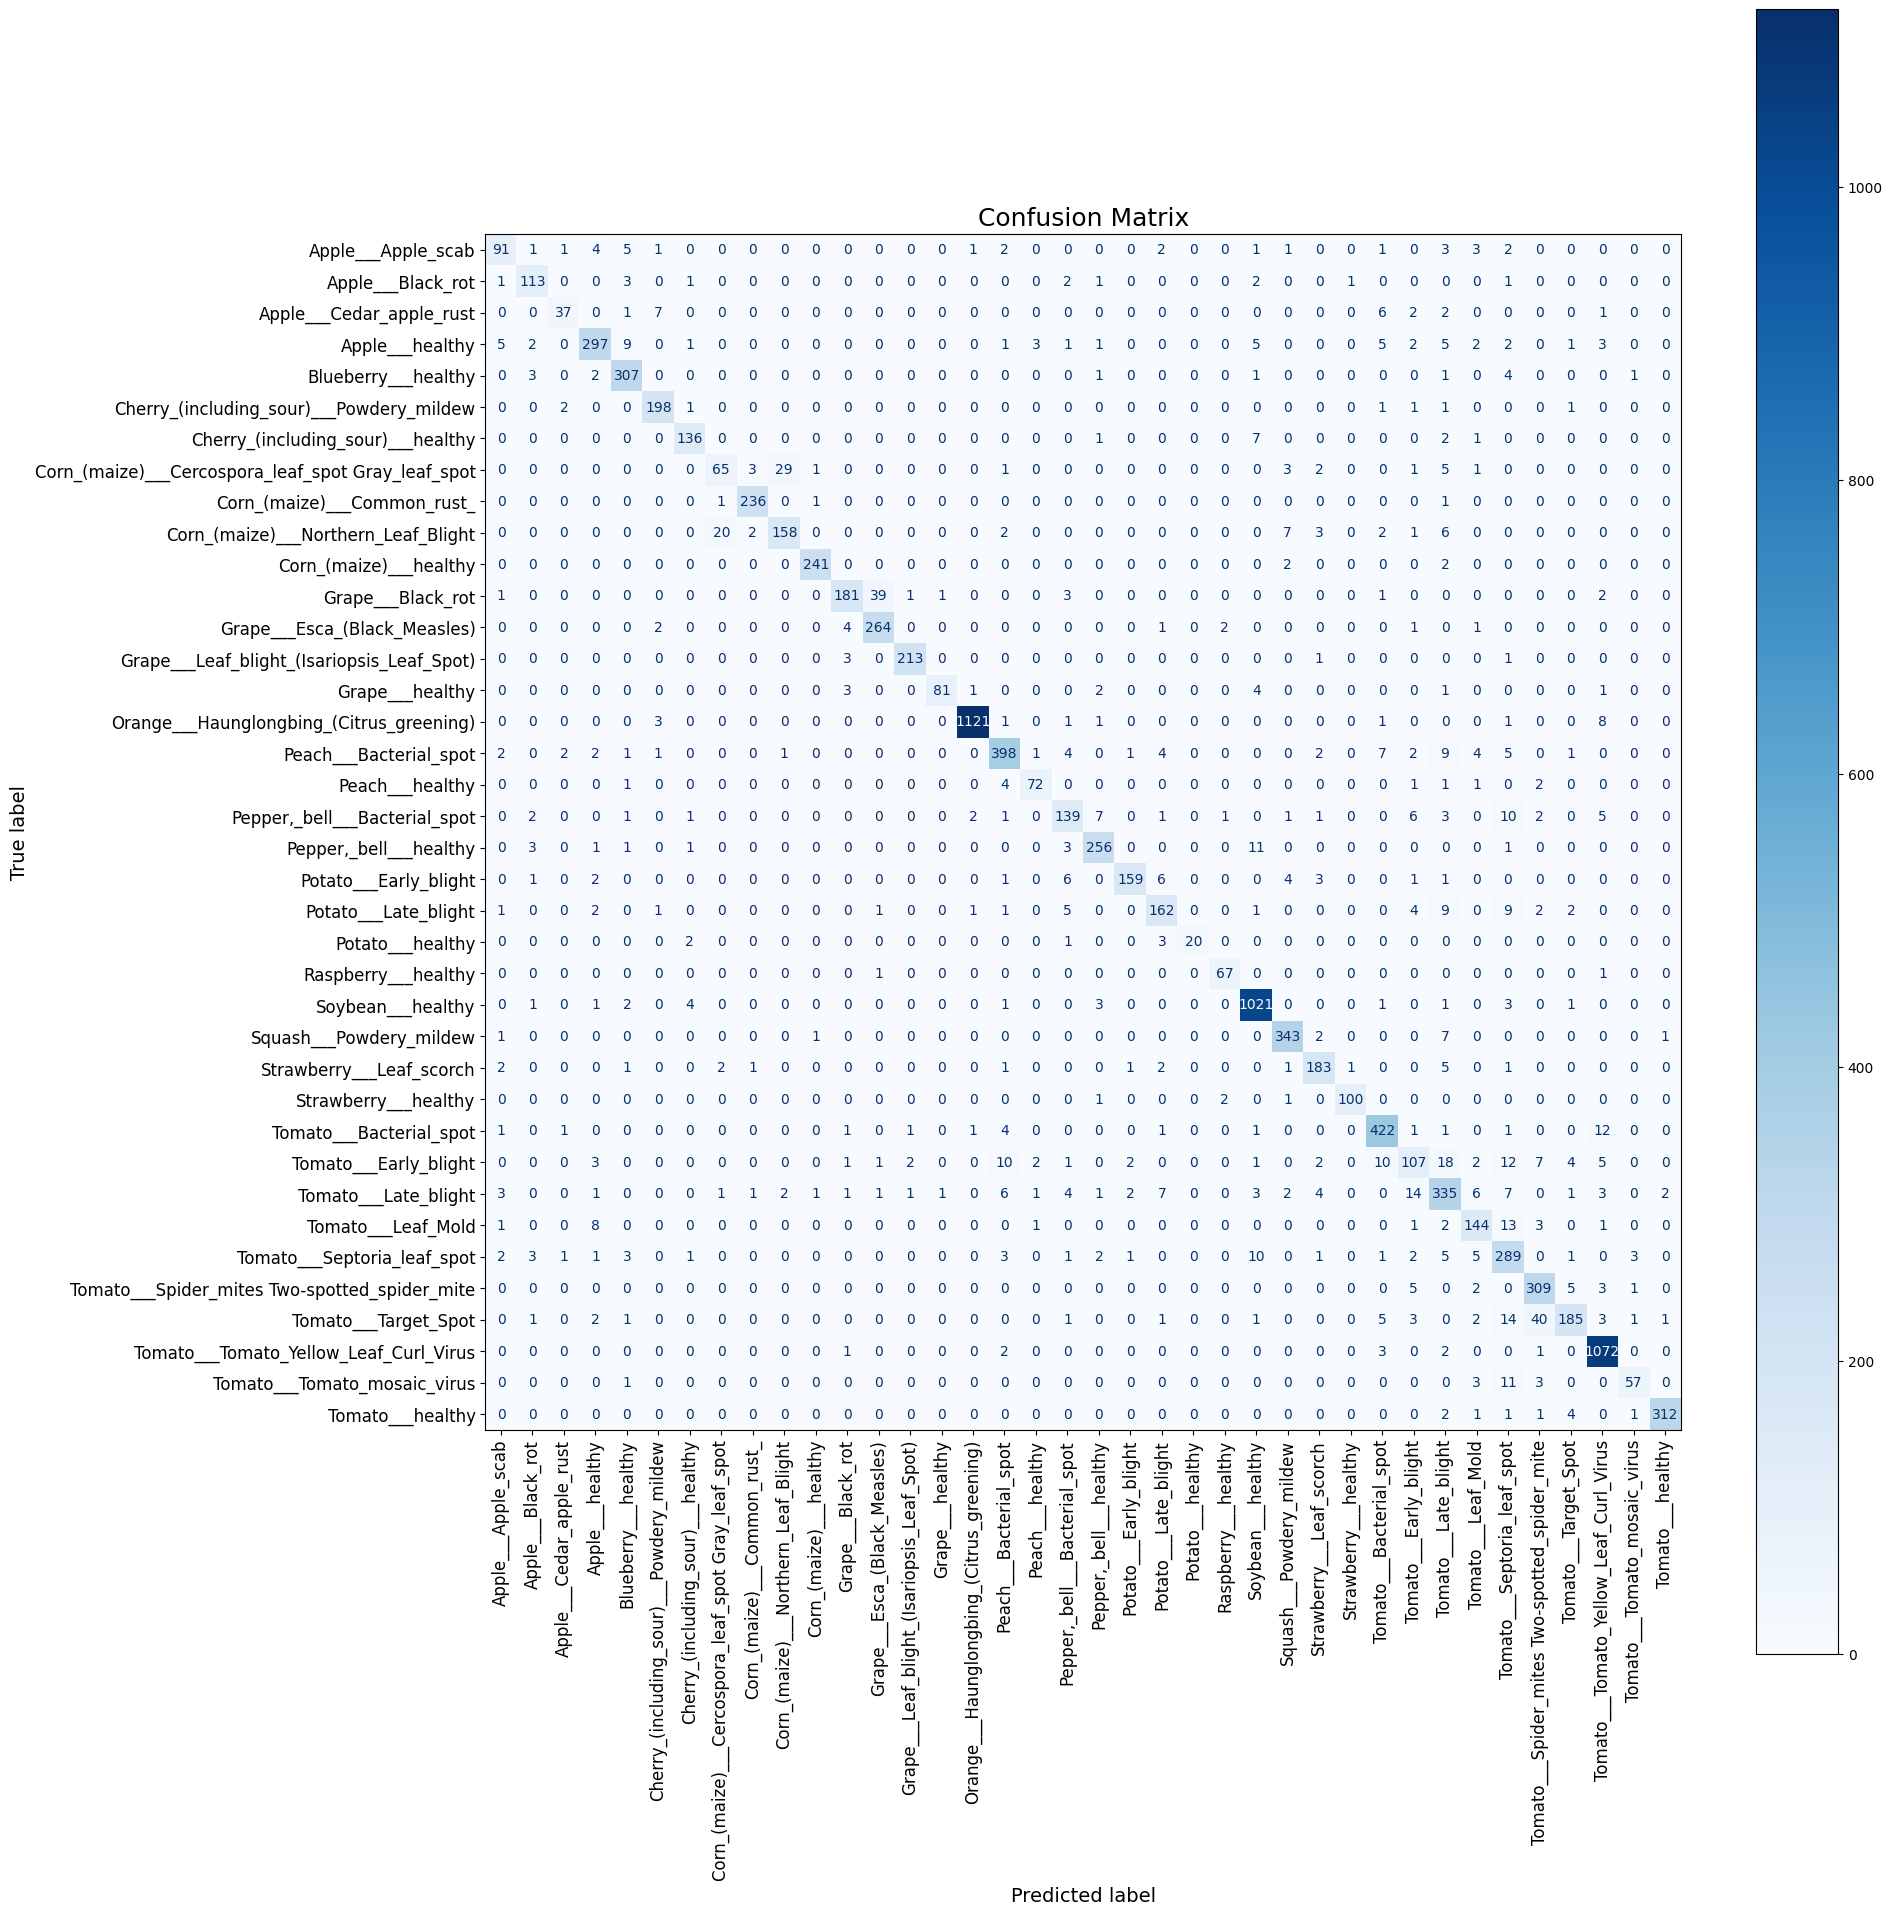

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Vérification du nombre de labels et de classes
assert len(unique_classes) == len(adjusted_class_names), "Le nombre de labels ne correspond pas au nombre de classes uniques."

# Augmentation de la taille de la figure
plt.figure(figsize=(20, 20))

# Création de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adjusted_class_names)

# Ajout des annotations
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, values_format='.0f', ax=plt.gca())

# Ajout des titres et labels avec taille de police ajustée
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Sauvegarder la matrice de confusion améliorée
plt.savefig(os.path.join(model_dir, 'confusion_matrix_improved.png'))
plt.show()




In [9]:
# Copier les fichiers vers Google Drive
model.save('CNN1.keras')
shutil.copy('CNN1.keras', os.path.join(model_dir, 'CNN1.keras'))

'/content/drive/My Drive/ColabResults/CNN_Model_224x224_B32_LR0.0001_E20_20240716-155334/CNN1.keras'